In [32]:
# Import Necessary Libraries
import os
import json
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import tensorflow_probability as tfp
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

# Load Files
all_playground_data = pd.read_csv("assets/playground/all_playground_data.csv")
pbp_2022 = pd.read_csv("assets/nflverse/pbp_2022.csv", low_memory=False)

# offensive route categories
offense_categories = {
    "blocking": ["Run Block", "Pass Block", "Lead Block", "Kneel Block", "Quick Block", "Spike Assist"],
    "routes": ["HITCH", "POST", "CORNER", "OUT", "GO", "SCREEN", "FLAT", "ANGLE", "CROSS", "IN", "SLANT", "WHEEL"],
    "special_actions": ["Kneel", "Kneel Assist", "Spike", "Stationary"],
    "no_assignment": ["No Route"]
}

# defensive coverage categories
defense_categories = {
    "run_defense": ["Contain", "Deep Run Support", "Run Contain", "Cutback Contain", "General Run Defense", "Force", "Gap Control", "Gap Fill", "Inside Gap"],
    "zone_defense": ["Zone Coverage", "Hook Zone", "Flat Zone Right", "Flat Zone Left", "Deep Zone", "Deep Third Right", "HCR", "HCL", "CFL"],
    "man_defense": ["MAN", "HOL", "FR", "3M", "3R", "3L", "2R", "2L", "FL"],
    "pass_rush": ["Pass Rush", "4IR", "4OL", "4IL", "4OR", "DF", "PRE"],
    "miscellaneous": ["Unknown Assignment", "CFR"],
    "special_defense": ["Deep Run Support", "Deep Third Right", "Flat Zone Right", "Flat Zone Left"]
}


# Helper function to calculate category proportions
def calculate_proportions(features, categories):
    results = {}
    for category, values in categories.items():
        results[f"{category}_ratio"] = features.apply(lambda x: sum(val in values for val in x), axis=1) / len(features.columns)
    return results

# Extract offense and defense columns
offense_columns = [col for col in all_playground_data.columns if "offense_player" in col and "routeRan" in col]
defense_columns = [col for col in all_playground_data.columns if "defense_player" in col and "cover_assignment" in col]

# Calculate offense ratios
offense_features = all_playground_data[offense_columns]
offense_ratios = calculate_proportions(offense_features, offense_categories)
for col, values in offense_ratios.items():
    all_playground_data[col] = values

# Calculate defense ratios
defense_features = all_playground_data[defense_columns]
defense_ratios = calculate_proportions(defense_features, defense_categories)
for col, values in defense_ratios.items():
    all_playground_data[col] = values


# offensive position categories
offensive_position_categories = {
    "skill_players": ["QB", "WR", "TE", "RB", "FB"],
    "offensive_line": ["T", "G", "C"],
    "uncommon_positions": ["OLB", "ILB", "DT", "FS"]
}

# defensive position categories
defensive_position_categories = {
    "defensive_line": ["DT", "DE", "NT"],
    "linebackers": ["OLB", "MLB", "ILB", "LB"],
    "defensive_backs": ["FS", "SS", "CB", "DB"],
    "non_traditional": ["QB", "WR"]
}

# Helper function to calculate position-based features
def calculate_position_features(features, categories):
    results = {}
    for category, positions in categories.items():
        # Count players in each category
        results[f"{category}_count"] = features.apply(lambda x: sum(pos in positions for pos in x), axis=1)
        # Proportion of players in each category
        results[f"{category}_ratio"] = results[f"{category}_count"] / len(features.columns)
    return results

# Extract offense and defense position columns
offense_position_columns = [col for col in all_playground_data.columns if "offense_player" in col and "position" in col]
defense_position_columns = [col for col in all_playground_data.columns if "defense_player" in col and "position" in col]

# Calculate offensive position features
offense_position_features = all_playground_data[offense_position_columns]
offense_positions = calculate_position_features(offense_position_features, offensive_position_categories)

# Calculate defensive position features
defense_position_features = all_playground_data[defense_position_columns]
defense_positions = calculate_position_features(defense_position_features, defensive_position_categories)

# Convert results to DataFrames
offense_positions_df = pd.DataFrame(offense_positions)
defense_positions_df = pd.DataFrame(defense_positions)

# Concatenate the calculated features with the original DataFrame
all_playground_data = pd.concat([all_playground_data, offense_positions_df, defense_positions_df], axis=1)

In [33]:
class PlayerDataProcessor:
    def __init__(self, all_playground_data):
        self.all_playground_data = all_playground_data
        self.player_position_mapping = {
            'Cameron Sample': 'DE',
            'Daxton Hill': 'CB',
            'Decobie Durant': 'CB',
            'Jacob Martin': 'DE',
            'Jeffrey Gunter': 'DE',
            'Joe Fortson': 'TE',
            'Josh Allen': 'QB',
            'Kyric Mcgowan': 'WR',
            'Manny Jones': 'DT',
            'Phillip Walker': 'QB',
            'Robby Anderson': 'WR',
            'Zachary Carter': 'DT'
        }
        all_playground_data['strategy'] = all_playground_data['strategy'].fillna('Unknown Strategy')

    def update_positions(self):
        for i in range(1, 12):
            offense_name_col = f'offense_player_{i}_name'
            offense_position_col = f'offense_player_{i}_position'
            if offense_name_col in self.all_playground_data.columns and offense_position_col in self.all_playground_data.columns:
                self.all_playground_data[offense_position_col] = self.all_playground_data.apply(
                    lambda row: self.player_position_mapping.get(row[offense_name_col], row[offense_position_col])
                    if pd.isna(row[offense_position_col]) else row[offense_position_col],
                    axis=1
                )

            defense_name_col = f'defense_player_{i}_name'
            defense_position_col = f'defense_player_{i}_position'
            if defense_name_col in self.all_playground_data.columns and defense_position_col in self.all_playground_data.columns:
                self.all_playground_data[defense_position_col] = self.all_playground_data.apply(
                    lambda row: self.player_position_mapping.get(row[defense_name_col], row[defense_position_col])
                    if pd.isna(row[defense_position_col]) else row[defense_position_col],
                    axis=1
                )

    @staticmethod
    def fill_routes(row, play_type, position, route):
        if play_type == 'qb_kneel':
            if position in ['C', 'G', 'T']:
                return 'Kneel Block'
            elif position in ['RB', 'FB']:
                return 'Kneel Assist'
            elif position in ['WR', 'TE']:
                return 'Stationary'
            elif position == 'QB':
                return 'Kneel'

        elif play_type == 'qb_spike':
            if position in ['C', 'G', 'T']:
                return 'Quick Block'
            elif position in ['RB', 'FB']:
                return 'Spike Assist'
            elif position in ['WR', 'TE']:
                return 'Stationary'
            elif position == 'QB':
                return 'Spike'

        if play_type == 'pass':
            if position in ['C', 'G', 'T']:
                return 'Pass Block'
            elif position in ['DT', 'FS', 'ILB', 'OLB', 'QB']:
                return 'No Route'
            elif position in ['FB', 'RB', 'TE']:
                return 'Pass Block' if pd.isna(route) else route
            elif position in ['WR']:
                return 'No Route' if pd.isna(route) else route

        elif play_type == 'run':
            if position in ['C', 'G', 'T']:
                return 'Run Block'
            elif position in ['DT', 'FS', 'ILB', 'OLB']:
                return 'Run Block'
            elif position in ['FB', 'RB', 'TE']:
                return 'Lead Block'
            elif position == 'QB':
                return 'No Route'
            elif position in ['WR']:
                return 'No Route' if pd.isna(route) else route

        if pd.isna(route):
            return 'No Route' if play_type == 'pass' else 'Run Block'
        return route

    def update_routes(self):
        for i in range(1, 12):
            position_col = f'offense_player_{i}_position'
            route_col = f'offense_player_{i}_routeRan'
            if position_col in self.all_playground_data.columns and route_col in self.all_playground_data.columns:
                self.all_playground_data[route_col] = self.all_playground_data.apply(
                    lambda row: self.fill_routes(row, row['play_type'], row[position_col], row[route_col]),
                    axis=1
                )

    @staticmethod
    def classify_coverage_with_context(row):
        if pd.isna(row['pff_manZone']):
            formation = row['defenseFormation']
            down = row['down']
            yards_to_go = row['yardsToGo']
            play_type = row['play_type']

            man_formations = [
                '4-3 Defense', '5-2 Defense', 'Heavy LB Defense', '3-4 Defense', 'Heavy DE Front', 'LB Heavy Defense'
            ]
            zone_formations = [
                '4-2-5 Nickel', 'Big Secondary and LB', 'Secondary Emphasis with DT', 
                '3-1-7 Quarter', 'Big Nickel', '4-1-6 Dime'
            ]

            if formation in man_formations:
                if play_type == 'run':
                    return 'Man'
                elif yards_to_go <= 5:
                    return 'Man'
                elif down == 3 and yards_to_go > 8:
                    return 'Zone'
                else:
                    return 'Man'
            elif formation in zone_formations:
                if play_type == 'pass':
                    return 'Zone'
                elif down == 3 and yards_to_go > 8:
                    return 'Zone'
                else:
                    return 'Zone'

            return 'Other'
        else:
            return row['pff_manZone']

    def classify_coverage(self):
        self.all_playground_data['pff_manZone'] = self.all_playground_data.apply(self.classify_coverage_with_context, axis=1)

    def cluster_plays(self):
        self.all_playground_data['play_type_encoded'] = LabelEncoder().fit_transform(self.all_playground_data['play_type'])
        self.all_playground_data['offenseFormation'] = self.all_playground_data['offenseFormation'].fillna('UNKNOWN')
        features = ['play_type_encoded', 'down', 'yardsToGo']
        kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
        self.all_playground_data['cluster'] = kmeans.fit_predict(self.all_playground_data[features])
        cluster_formation_mapping = self.all_playground_data.groupby('cluster')['offenseFormation'].apply(lambda x: x.mode().iloc[0])
        self.all_playground_data['offenseFormation'] = self.all_playground_data.apply(
            lambda row: cluster_formation_mapping[row['cluster']] if row['offenseFormation'] == 'UNKNOWN' else row['offenseFormation'],
            axis=1
        )

    @staticmethod
    def create_feature_row(row):
        positions = [row[f'offense_player_{i}_position'] for i in range(1, 12)]
        return {
            'wr_count': positions.count('WR'),
            'te_count': positions.count('TE'),
            'rb_count': positions.count('RB'),
            'play_type_encoded': (
                1 if row['play_type'] == 'pass' else 
                2 if row['play_type'] == 'run' else
                3 if row['play_type'] == 'qb_kneel' else
                4 if row['play_type'] == 'qb_spike' else 0
            )
        }

    def cluster_features(self):
        features = pd.DataFrame([self.create_feature_row(row) for _, row in self.all_playground_data.iterrows()])
        kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
        features['cluster'] = kmeans.fit_predict(features[['wr_count', 'te_count', 'rb_count', 'play_type_encoded']])
        self.all_playground_data['cluster'] = features['cluster']
        alignment_mapping = (
            self.all_playground_data[self.all_playground_data['receiverAlignment'].notna()]
            .groupby('cluster')['receiverAlignment']
            .apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
        )
        self.all_playground_data['receiverAlignment'] = self.all_playground_data.apply(
            lambda row: alignment_mapping.get(row['cluster'], 'Unknown') if pd.isna(row['receiverAlignment']) else row['receiverAlignment'],
            axis=1
        )

    @staticmethod
    def fill_cover_assignment(cover_assignment, position, formation, play_type, down, yards_to_go):
        """
        Assigns coverage responsibilities based on position, formation, play type, down, and yards to go.
        """
        # Return existing assignment if already present
        if pd.notna(cover_assignment):
            return cover_assignment

        # Short, medium, and long yardage categories
        short_yardage = yards_to_go <= 3
        medium_yardage = 4 <= yards_to_go <= 7
        long_yardage = yards_to_go >= 8

        # For 'Run' play type
        if play_type == 'run':
            # Defensive Linemen (DE, DT, NT)
            if position in ['DE', 'DT', 'NT']:
                return 'Gap Control' if short_yardage else 'Inside Gap'

            # Linebackers (LB, OLB, MLB, ILB)
            elif position in ['LB', 'OLB', 'MLB', 'ILB']:
                if formation in ['4-3 Defense', '3-4 Defense']:
                    return 'Gap Fill' if short_yardage else 'Contain'
                return 'Run Support'

            # Cornerbacks (CB)
            elif position == 'CB':
                return 'Force' if short_yardage else 'Run Contain'

            # Safeties (SS, FS)
            elif position in ['SS', 'FS']:
                return 'Cutback Contain' if short_yardage else 'Deep Run Support'

            # Defensive Backs (DB)
            elif position == 'DB':
                return 'Run Contain'

            # Fallback for unhandled cases
            return 'General Run Defense'

        # For 'Pass' play type
        elif play_type == 'pass':
            # Defensive Linemen (DE, DT, NT)
            if position in ['DE', 'DT', 'NT']:
                return 'Pass Rush'

            # Linebackers (LB, OLB, MLB, ILB)
            elif position in ['LB', 'OLB', 'MLB', 'ILB']:
                if short_yardage:
                    return 'Hook Zone'
                elif medium_yardage:
                    return 'HCR'  # Hook/Curl Right
                elif long_yardage:
                    return 'Zone Coverage'

            # Cornerbacks (CB)
            elif position == 'CB':
                if short_yardage:
                    return 'MAN'
                elif medium_yardage:
                    return 'Flat Zone Right'
                elif long_yardage:
                    return 'Deep Third Right'

            # Safeties (SS, FS)
            elif position in ['SS', 'FS']:
                if short_yardage:
                    return 'Run Support'
                elif medium_yardage:
                    return 'Deep Zone'
                elif long_yardage:
                    return 'DF'  

            # Defensive Backs (DB)
            elif position == 'DB':
                if short_yardage:
                    return 'Flat Zone Left'
                elif long_yardage:
                    return 'Zone Coverage'

            # Fallback for unhandled cases
            return 'Zone Coverage'

        # Fallback for unrecognized play types
        return 'Unknown Assignment'


    
    def update_cover_assignments(self):
        for i in range(1, 12):  # Assuming up to 11 defensive players
            cover_assignment_col = f'defense_player_{i}_cover_assignment'
            position_col = f'defense_player_{i}_position'
            if cover_assignment_col in self.all_playground_data.columns:
                self.all_playground_data[cover_assignment_col] = self.all_playground_data.apply(
                    lambda row: self.fill_cover_assignment(
                        row[cover_assignment_col],
                        row[position_col],
                        row['defenseFormation'],
                        row['play_type'],
                        row['down'],
                        row['yardsToGo']
                    ),
                    axis=1
                )

In [34]:
processor = PlayerDataProcessor(all_playground_data)
processor.update_positions()
processor.update_routes()
processor.classify_coverage()
processor.cluster_plays()
processor.cluster_features()
processor.update_cover_assignments()
processed_df = processor.all_playground_data

In [35]:
# Ensure yardsGained is numeric
all_playground_data['yardsGained'] = pd.to_numeric(all_playground_data['yardsGained'], errors='coerce')

# Define bin edges
bin_edges = [-100, -40, -30, -20, -10, 0, 1, 6, 11, 21, 31, 41, 100]

# corresponding labels
bin_labels = ["-100 to -40", "-40 to -30", "-30 to -20", "-20 to -10", "-10 to -1", "0", "1 to 5", "6 to 10", "11 to 20", "21 to 30", "31 to 40", "41 to 100"]

# Perform the cut
all_playground_data['yardsGained'] = pd.cut(all_playground_data['yardsGained'], bins=bin_edges, labels=bin_labels, right=False)

# List of columns not to be selected
exclude_columns = ['season', 'nflid', 'receiverAlignment', 'cluster', 'play_type_encoded','passer_player_name', 'receiver_player_name']
last_column_name = 'yardsGained'

# Rearrange DataFrame columns to exclude specified columns but keep 'yardsGained' last
all_playground_data = processed_df[[col for col in processed_df.columns if col not in exclude_columns and col != last_column_name] + [last_column_name]]

In [36]:
# Drop duplicate columns before merging
pbp_2022 = pbp_2022.drop(columns=['down', 'play_type'])

# Merge the DataFrames
merged_df = pd.merge(all_playground_data, pbp_2022, left_on=['gameId', 'playId','week'], right_on=['old_game_id', 'play_id','week'], how='left')

# 1. Offense Player Columns
offense_columns = []
for i in range(1, 12):
    offense_columns.extend([
        f'offense_player_{i}_name',
        f'offense_player_{i}_position',
        f'offense_player_{i}_routeRan',
        f'offense_player_{i}_rating'
    ])

# 2. Defense Player Columns
defense_columns = []
for i in range(1, 12):
    defense_columns.extend([
        f'defense_player_{i}_name',
        f'defense_player_{i}_position',
        f'defense_player_{i}_cover_assignment',
        f'defense_player_{i}_rating'
    ])

# 3. Game Information Columns
game_info_columns = [
    'game_id', 'old_game_id', 'play_id', 'home_team', 'away_team', 'season_type',
    'posteam', 'defteam', 'side_of_field', 'game_date', 'drive', 'sp', 'qtr',
    'time', 'yrdln', 'shotgun', 'no_huddle'
]

# 4. Quarterback Actions
qb_actions = [
    'qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble'
]

# 5. Play Details
play_details = [
    'pass_length', 'pass_location', 'air_yards', 'yards_after_catch',
    'run_location', 'run_gap', 'field_goal_result', 'kick_distance',
    'extra_point_result', 'two_point_conv_result'
]

# 6. Score and Probability Columns
score_prob_columns = [
    'home_timeouts_remaining', 'away_timeouts_remaining', 'timeout',
    'timeout_team', 'td_team', 'td_player_name', 'td_player_id',
    'total_home_score', 'total_away_score', 'posteam_score_post',
    'defteam_score_post', 'score_differential_post', 'no_score_prob',
    'opp_fg_prob', 'opp_safety_prob', 'opp_td_prob', 'fg_prob',
    'safety_prob', 'td_prob', 'extra_point_prob', 'two_point_conversion_prob'
]

# 7. Expected Points and EPA Columns
epa_columns = [
    'ep', 'epa', 'total_home_epa', 'total_away_epa', 'total_home_rush_epa',
    'total_away_rush_epa', 'total_home_pass_epa', 'total_away_pass_epa',
    'air_epa', 'yac_epa', 'comp_air_epa', 'comp_yac_epa',
    'total_home_comp_air_epa', 'total_away_comp_air_epa',
    'total_home_comp_yac_epa', 'total_away_comp_yac_epa',
    'total_home_raw_air_epa', 'total_away_raw_air_epa',
    'total_home_raw_yac_epa', 'total_away_raw_yac_epa'
]

# 8. Win Probability Columns
wp_columns = [
    'home_wp', 'away_wp', 'wpa', 'vegas_wpa', 'vegas_home_wpa',
    'home_wp_post', 'away_wp_post', 'vegas_wp', 'vegas_home_wp',
    'total_home_rush_wpa', 'total_away_rush_wpa',
    'total_home_pass_wpa', 'total_away_pass_wpa', 'air_wpa', 'yac_wpa',
    'comp_air_wpa', 'comp_yac_wpa', 'total_home_comp_air_wpa',
    'total_away_comp_air_wpa', 'total_home_comp_yac_wpa',
    'total_away_comp_yac_wpa', 'total_home_raw_air_wpa',
    'total_away_raw_air_wpa', 'total_home_raw_yac_wpa',
    'total_away_raw_yac_wpa'
]

# 9. Play Outcome Columns
play_outcomes = [
    'punt_blocked', 'first_down_rush', 'first_down_pass',
    'first_down_penalty', 'third_down_converted', 'third_down_failed',
    'fourth_down_converted', 'fourth_down_failed', 'incomplete_pass',
    'touchback', 'interception', 'punt_inside_twenty',
    'punt_in_endzone', 'punt_out_of_bounds', 'punt_downed',
    'punt_fair_catch', 'kickoff_inside_twenty', 'kickoff_in_endzone',
    'kickoff_out_of_bounds', 'kickoff_downed', 'kickoff_fair_catch',
    'fumble_forced', 'fumble_not_forced', 'fumble_out_of_bounds',
    'solo_tackle', 'safety', 'penalty', 'tackled_for_loss',
    'fumble_lost', 'own_kickoff_recovery', 'own_kickoff_recovery_td',
    'qb_hit', 'rush_attempt', 'pass_attempt', 'sack', 'touchdown',
    'pass_touchdown', 'rush_touchdown', 'return_touchdown',
    'extra_point_attempt', 'two_point_attempt', 'field_goal_attempt',
    'kickoff_attempt', 'punt_attempt', 'fumble', 'complete_pass',
    'assist_tackle', 'lateral_reception', 'lateral_rush',
    'lateral_return', 'lateral_recovery', 'passer_player_id',
    'passer_player_name', 'passing_yards', 'receiver_player_id',
    'receiver_player_name', 'receiving_yards', 'rusher_player_id',
    'rusher_player_name', 'rushing_yards', 'lateral_receiver_player_id',
    'lateral_receiver_player_name', 'lateral_receiving_yards',
    'lateral_rusher_player_id', 'lateral_rusher_player_name',
    'lateral_rushing_yards', 'lateral_sack_player_id',
    'lateral_sack_player_name', 'interception_player_id',
    'interception_player_name', 'lateral_interception_player_id',
    'lateral_interception_player_name', 'punt_returner_player_id',
    'punt_returner_player_name', 'lateral_punt_returner_player_id',
    'lateral_punt_returner_player_name', 'kickoff_returner_player_name',
    'kickoff_returner_player_id', 'lateral_kickoff_returner_player_id',
    'lateral_kickoff_returner_player_name', 'punter_player_id',
    'punter_player_name', 'kicker_player_name', 'kicker_player_id',
    'own_kickoff_recovery_player_id', 'own_kickoff_recovery_player_name',
    'blocked_player_id', 'blocked_player_name',
    'tackle_for_loss_1_player_id', 'tackle_for_loss_1_player_name',
    'tackle_for_loss_2_player_id', 'tackle_for_loss_2_player_name',
    'qb_hit_1_player_id', 'qb_hit_1_player_name', 'qb_hit_2_player_id',
    'qb_hit_2_player_name', 'forced_fumble_player_1_team',
    'forced_fumble_player_1_player_id', 'forced_fumble_player_1_player_name',
    'forced_fumble_player_2_team', 'forced_fumble_player_2_player_id',
    'forced_fumble_player_2_player_name', 'solo_tackle_1_team',
    'solo_tackle_2_team', 'solo_tackle_1_player_id',
    'solo_tackle_2_player_id', 'solo_tackle_1_player_name',
    'solo_tackle_2_player_name', 'assist_tackle_1_player_id',
    'assist_tackle_1_player_name', 'assist_tackle_1_team',
    'assist_tackle_2_player_id', 'assist_tackle_2_player_name',
    'assist_tackle_2_team', 'assist_tackle_3_player_id',
    'assist_tackle_3_player_name', 'assist_tackle_3_team',
    'assist_tackle_4_player_id', 'assist_tackle_4_player_name',
    'assist_tackle_4_team', 'tackle_with_assist',
    'tackle_with_assist_1_player_id', 'tackle_with_assist_1_player_name',
    'tackle_with_assist_1_team', 'tackle_with_assist_2_player_id',
    'tackle_with_assist_2_player_name', 'tackle_with_assist_2_team',
    'pass_defense_1_player_id', 'pass_defense_1_player_name',
    'pass_defense_2_player_id', 'pass_defense_2_player_name',
    'fumbled_1_team', 'fumbled_1_player_id', 'fumbled_1_player_name',
    'fumbled_2_player_id', 'fumbled_2_player_name', 'fumbled_2_team',
    'fumble_recovery_1_team', 'fumble_recovery_1_yards',
    'fumble_recovery_1_player_id', 'fumble_recovery_1_player_name',
    'fumble_recovery_2_team', 'fumble_recovery_2_yards',
    'fumble_recovery_2_player_id', 'fumble_recovery_2_player_name',
    'sack_player_id', 'sack_player_name', 'half_sack_1_player_id',
    'half_sack_1_player_name', 'half_sack_2_player_id',
    'half_sack_2_player_name', 'return_team', 'return_yards',
    'penalty_team', 'penalty_player_id', 'penalty_player_name',
    'penalty_yards', 'replay_or_challenge',
    'replay_or_challenge_result', 'penalty_type',
    'defensive_two_point_attempt', 'defensive_two_point_conv',
    'defensive_extra_point_attempt', 'defensive_extra_point_conv',
    'safety_player_name', 'safety_player_id'
]

# 10. Season and Series Columns
season_series_columns = [
    'season', 'cp', 'cpoe', 'series', 'series_success',
    'series_result', 'order_sequence', 'start_time', 'time_of_day',
    'stadium', 'weather', 'nfl_api_id', 'play_clock',
    'play_deleted', 'play_type_nfl', 'special_teams_play',
    'st_play_type', 'end_clock_time', 'end_yard_line',
    'fixed_drive', 'fixed_drive_result', 'drive_real_start_time',
    'drive_play_count', 'drive_time_of_possession',
    'drive_first_downs', 'drive_inside20', 'drive_ended_with_score',
    'drive_quarter_start', 'drive_quarter_end',
    'drive_yards_penalized', 'drive_start_transition',
    'drive_end_transition', 'drive_game_clock_start',
    'drive_game_clock_end', 'drive_start_yard_line',
    'drive_end_yard_line', 'drive_play_id_started',
    'drive_play_id_ended'
]

# 11. Score and Betting Columns
score_betting_columns = [
    'away_score', 'home_score', 'location', 'result', 'total',
    'spread_line', 'total_line', 'div_game', 'roof', 'surface',
    'temp', 'wind', 'home_coach', 'away_coach', 'stadium_id',
    'game_stadium', 'aborted_play', 'passer', 'passer_jersey_number',
    'rusher', 'rusher_jersey_number', 'receiver',
    'receiver_jersey_number', 'pass', 'rush', 'first_down',
    'special', 'play', 'passer_id', 'rusher_id', 'receiver_id',
    'name', 'jersey_number', 'id', 'fantasy_player_name',
    'fantasy_player_id', 'fantasy', 'fantasy_id', 'out_of_bounds',
    'home_opening_kickoff', 'qb_epa', 'xyac_epa', 'xyac_mean_yardage',
    'xyac_median_yardage', 'xyac_success', 'xyac_fd', 'xpass',
    'pass_oe', 'desc', 'posteam_type'
]

# Combine all columns into a single list
columns_to_drop = (
    offense_columns +
    defense_columns +
    game_info_columns +
    qb_actions +
    play_details +
    score_prob_columns +
    epa_columns +
    wp_columns +
    play_outcomes +
    season_series_columns +
    score_betting_columns
)

# Drop the columns from merged_df
merged_df.drop(columns=columns_to_drop, axis=1, inplace=True)

# Interaction Feature
merged_df['down_yardsToGo'] = merged_df['down'] * merged_df['yardsToGo']

# Time Remaining Ratios
merged_df['quarter_time_ratio'] = merged_df['quarter_seconds_remaining'] / 900
merged_df['half_time_ratio'] = merged_df['half_seconds_remaining'] / 1800

# Normalized Score Differential
total_score = merged_df['posteam_score'] + merged_df['defteam_score']
merged_df['normalized_score_differential'] = merged_df['score_differential'] / total_score

# Timeout Usage Features
merged_df['posteam_timeout_usage'] = (3 - merged_df['posteam_timeouts_remaining']) / 3
merged_df['defteam_timeout_usage'] = (3 - merged_df['defteam_timeouts_remaining']) / 3

# Game Half Indicator
merged_df['is_second_half'] = (merged_df['game_half'] == 'Half2').astype(int)

# Normalize Down (1st = 0.25, 2nd = 0.50, 3rd = 0.75, 4th = 1.00)
merged_df['normalized_down'] = merged_df['down'] / 4

# Normalize Quarter (1st = 0.25, ..., 4th = 1.00)
merged_df['normalized_quarter'] = merged_df['quarter'] / 4

# Normalize Remaining Time (assuming max time is in seconds for a quarter)
max_time_quarter = 900  # total seconds in a quarter
merged_df['normalized_time_remaining'] = merged_df['quarter_seconds_remaining'] / max_time_quarter

# Create Situation Pressure Feature
merged_df['situation_pressure'] = (merged_df['normalized_down'] + merged_df['normalized_quarter'] + merged_df['normalized_time_remaining']) / 3

# Offense Defense Interaction
merged_df['offense_defense_interaction'] = merged_df['offenseFormation'].astype(str) + "_" + merged_df['defenseFormation'].astype(str)



# Lets have week 9 to be the unseen data for our testing
unseen_data_df = merged_df[merged_df['week'] == 9]

# train data
merged_df = merged_df[merged_df['week'] != 9]

# Get required fields
merged_df = merged_df[[
    "quarter", "down", "yardsToGo", "absoluteYardlineNumber", "offenseFormation", "play_type", "defenseFormation", 
    "pff_manZone", "average_offense_rating", "average_defense_rating", "quarter_seconds_remaining", "half_seconds_remaining",
    "game_seconds_remaining", "game_half", "goal_to_go", "posteam_timeouts_remaining", "defteam_timeouts_remaining", "posteam_score", 
    "defteam_score", "score_differential", "wp", "def_wp",'down_yardsToGo', 'quarter_time_ratio', 'half_time_ratio', 'normalized_score_differential', 
    'posteam_timeout_usage', 'defteam_timeout_usage', 'is_second_half', 'normalized_down', 'normalized_quarter','normalized_time_remaining',
    'situation_pressure', "offense_defense_interaction","blocking_ratio", "routes_ratio", "special_actions_ratio", "no_assignment_ratio", "run_defense_ratio", 
    "zone_defense_ratio", "man_defense_ratio", "pass_rush_ratio", "miscellaneous_ratio", "special_defense_ratio", "skill_players_count", "skill_players_ratio", 
    "offensive_line_count", "offensive_line_ratio", "uncommon_positions_count", "uncommon_positions_ratio", "defensive_line_count", "defensive_line_ratio", 
    "linebackers_count", "linebackers_ratio", "defensive_backs_count", "defensive_backs_ratio", "non_traditional_count",  "non_traditional_ratio", 
    "yardsGained", "strategy"
]]

df = merged_df.copy()

In [29]:
df = df[df['strategy'] != 'Unknown Strategy']
unseen_data_df = unseen_data_df[unseen_data_df['strategy'] != 'Unknown Strategy']

In [37]:
unseen_data_df.head().T

,415,416,417,418,419
week,9,9,9,9,9
gameId,2022110609,2022110609,2022110609,2022110609,2022110609
playId,62,84,105,500,522
quarter,1,1,1,1,1
down,1,2,3,1,2
yardsToGo,10,10,5,10,10
absoluteYardlineNumber,83,83,78,85,85
offenseFormation,SHOTGUN,SINGLEBACK,EMPTY,SINGLEBACK,SHOTGUN
play_type,pass,run,pass,pass,pass
defenseFormation,3-1-7 Quarter,3-1-7 Quarter,3-1-7 Quarter,3-1-7 Quarter,3-4 Defense


Class Distribution Before Resampling: {0: 213, 1: 2281, 2: 324, 3: 2094, 4: 218, 5: 37, 6: 76, 7: 1338, 8: 119, 9: 55, 10: 29, 11: 62, 12: 77, 13: 157, 14: 35, 15: 141, 16: 192, 17: 41, 18: 10, 19: 156, 20: 28, 21: 43, 22: 29, 23: 93, 24: 8, 25: 9, 26: 13, 27: 11, 28: 2, 29: 6}
No classes with <=1 samples detected.

Starting Fold 1/5
Epoch 1/20
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 53s 30ms/step - accuracy: 0.6400 - loss: 0.2261 - val_accuracy: 0.8630 - val_loss: 0.0684 - learning_rate: 0.0010
Epoch 2/20
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 51s 30ms/step - accuracy: 0.8554 - loss: 0.0727 - val_accuracy: 0.8991 - val_loss: 0.0525 - learning_rate: 0.0010
Epoch 3/20
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 51s 30ms/step - accuracy: 0.8920 - loss: 0.0560 - val_accuracy: 0.9113 - val_loss: 0.0537 - learning_rate: 0.0010
Epoch 4/20
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 51s 30ms/step - accuracy: 0.9095 - loss: 0.0509 - val_accuracy: 0.9147 - val_loss: 0.0515 - learning_rate: 0.0010
Epoch 5/20
1691/1691 ━━━━━━━━━━━━━━━━━━━

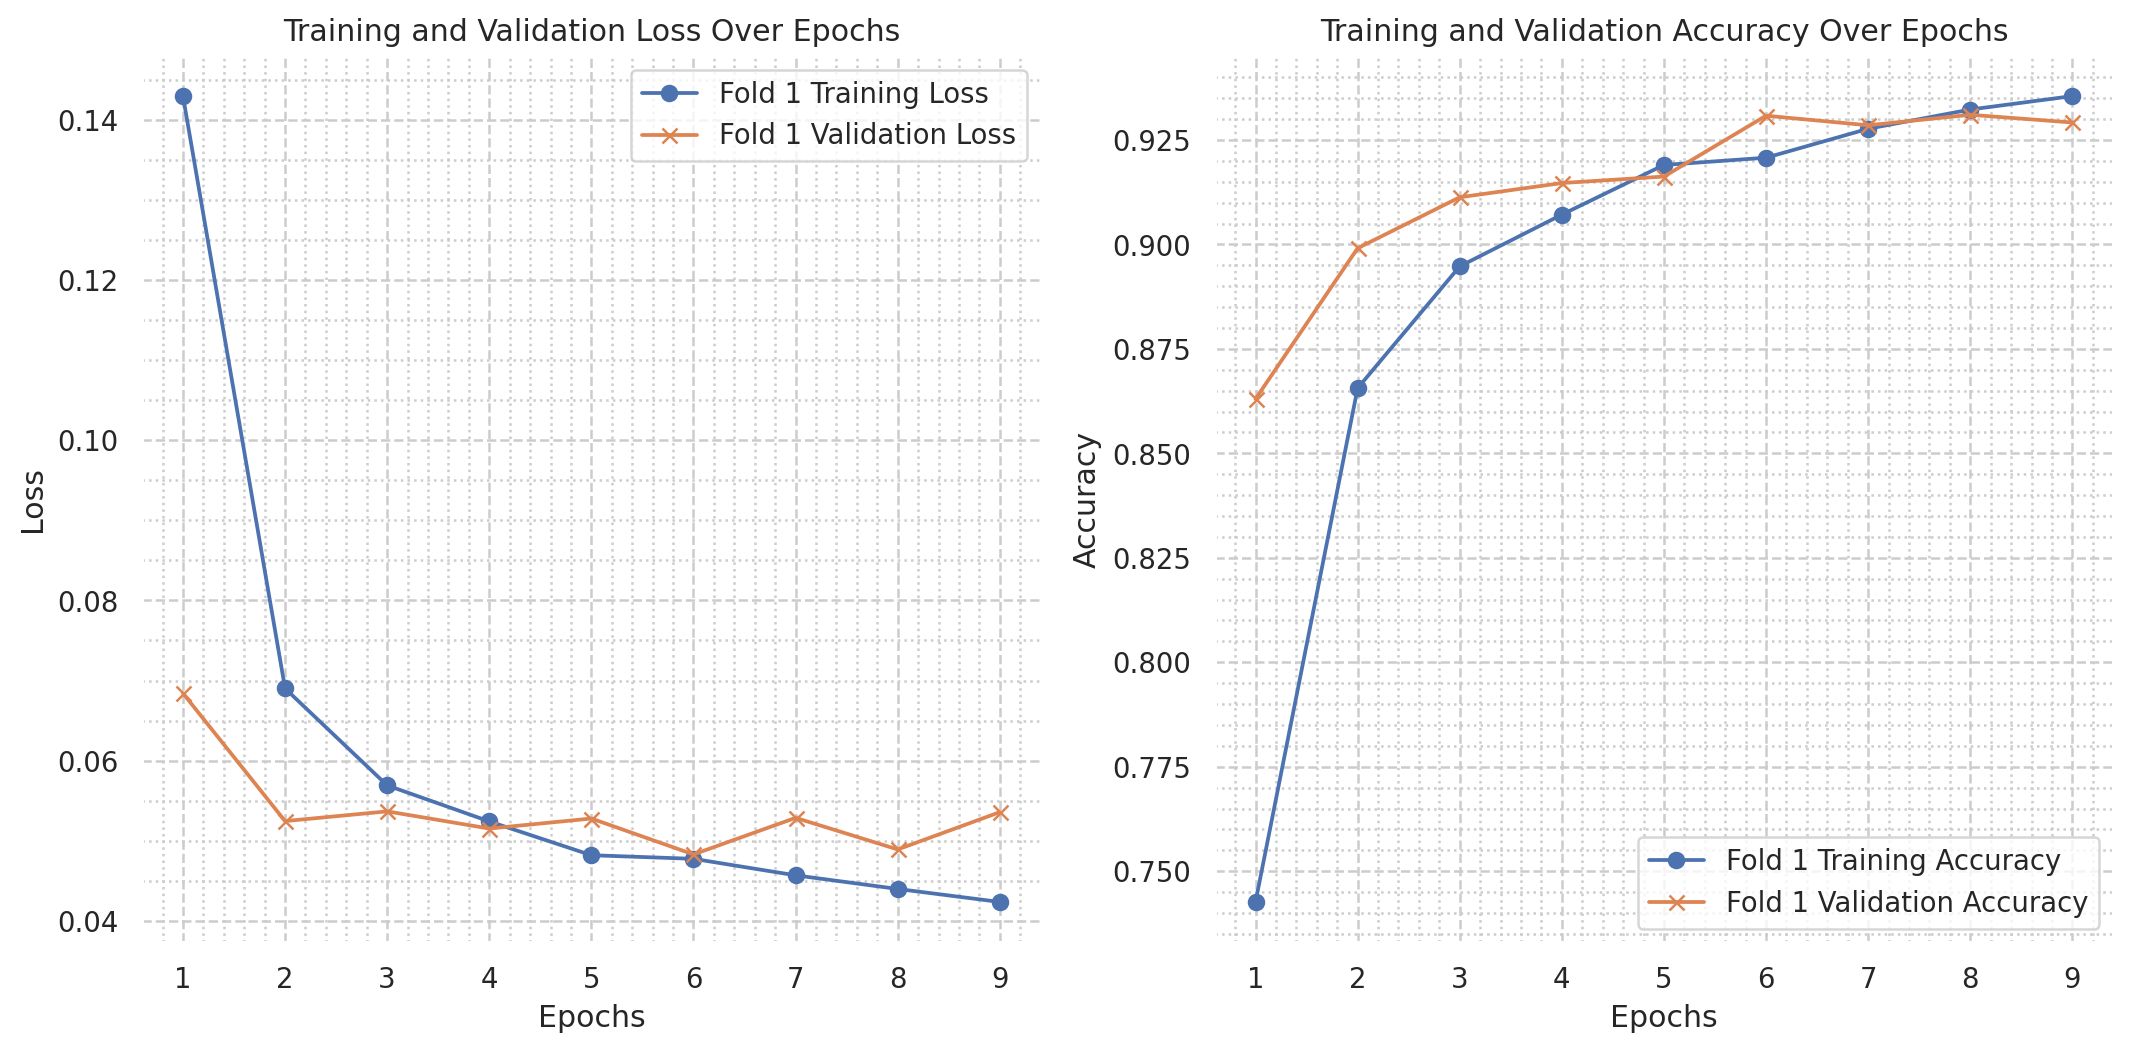


Starting Fold 2/5
Epoch 1/20
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 52s 30ms/step - accuracy: 0.6452 - loss: 0.2255 - val_accuracy: 0.8424 - val_loss: 0.0808 - learning_rate: 0.0010
Epoch 2/20
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 52s 31ms/step - accuracy: 0.8565 - loss: 0.0730 - val_accuracy: 0.9045 - val_loss: 0.0544 - learning_rate: 0.0010
Epoch 3/20
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 51s 30ms/step - accuracy: 0.8943 - loss: 0.0552 - val_accuracy: 0.9161 - val_loss: 0.0521 - learning_rate: 0.0010
Epoch 4/20
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 51s 30ms/step - accuracy: 0.9092 - loss: 0.0514 - val_accuracy: 0.9122 - val_loss: 0.0566 - learning_rate: 0.0010
Epoch 5/20
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 51s 30ms/step - accuracy: 0.9203 - loss: 0.0470 - val_accuracy: 0.9142 - val_loss: 0.0563 - learning_rate: 0.0010
Epoch 6/20
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 52s 31ms/step - accuracy: 0.9255 - loss: 0.0460 - val_accuracy: 0.9227 - val_loss: 0.0519 - learning_rate: 0.0010
Epoch 7/20
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 52s

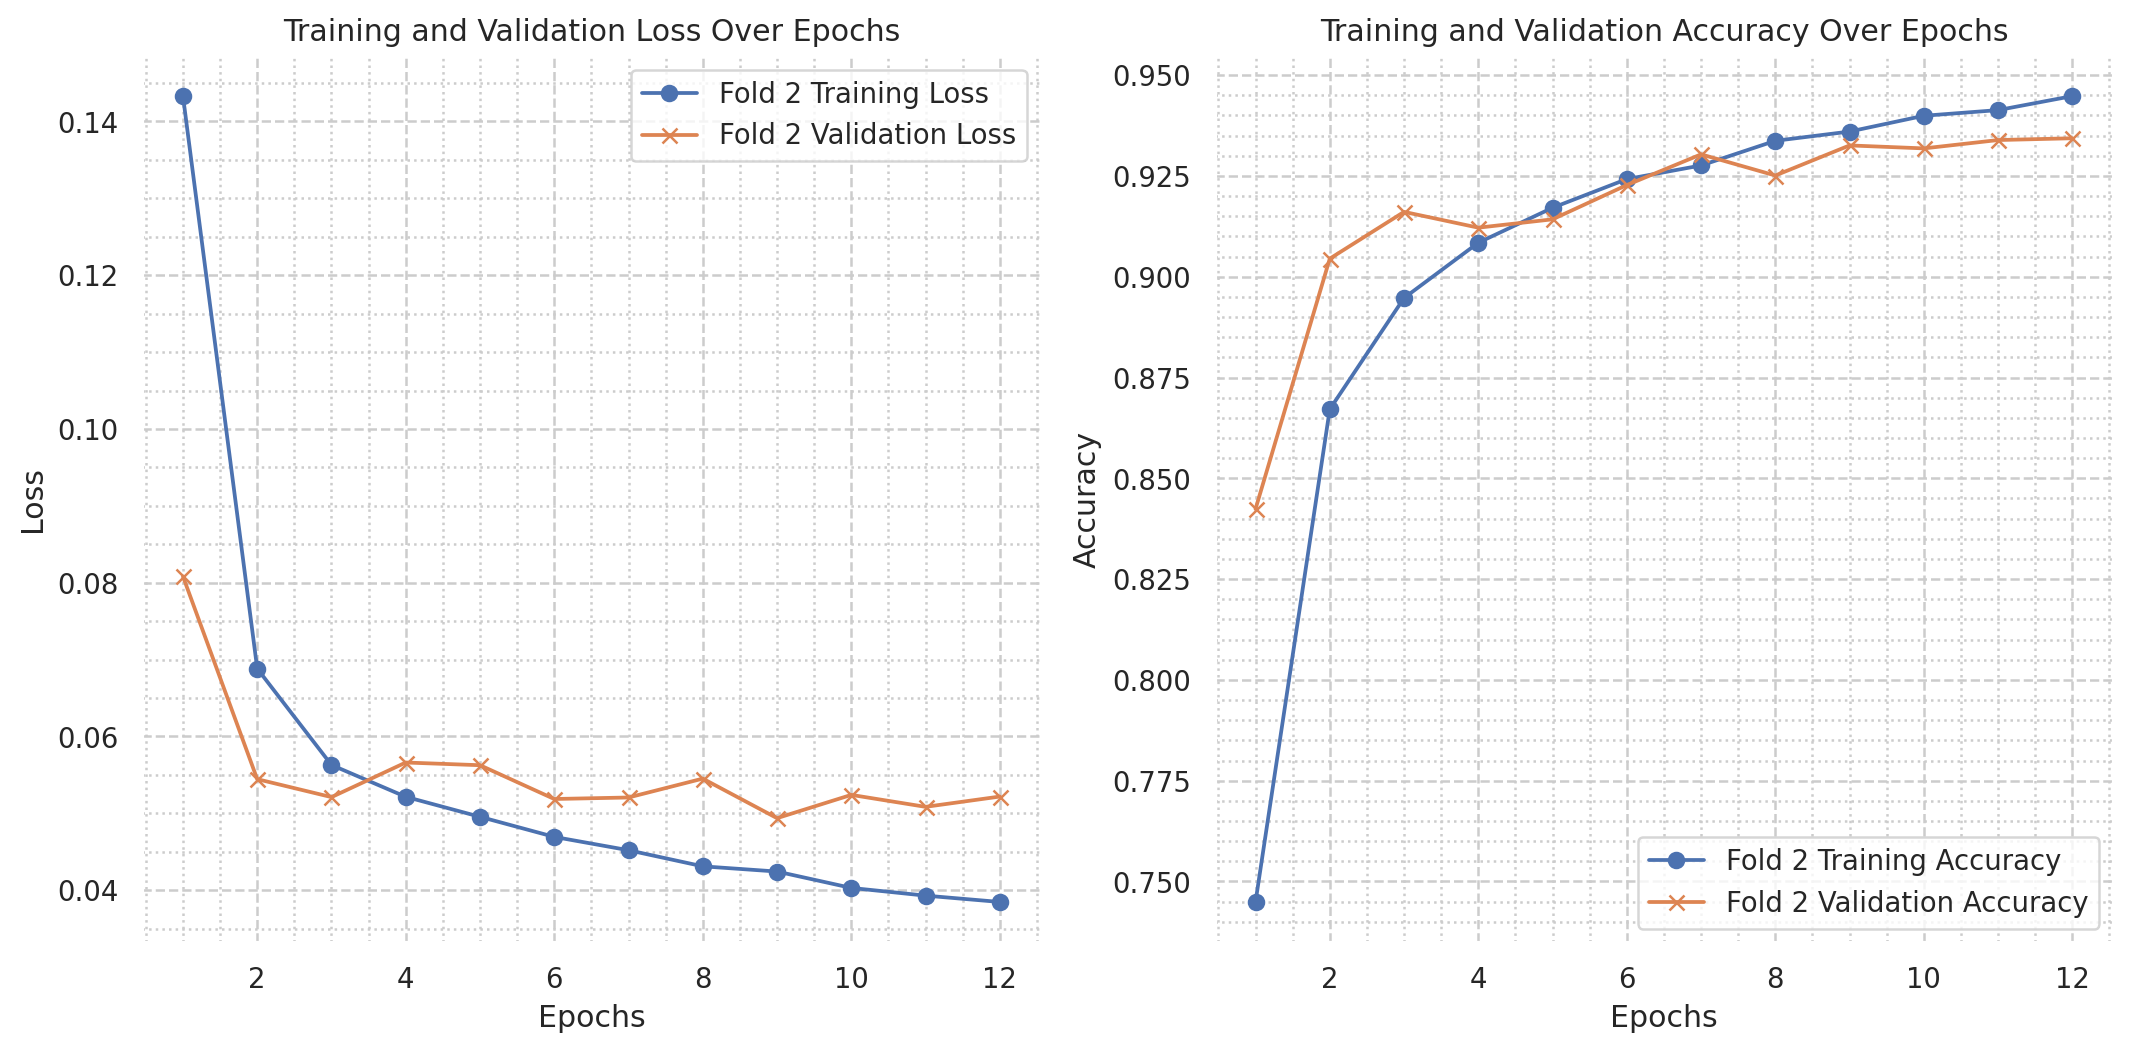


Starting Fold 3/5
Epoch 1/20
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 51s 29ms/step - accuracy: 0.6455 - loss: 0.2245 - val_accuracy: 0.8730 - val_loss: 0.0690 - learning_rate: 0.0010
Epoch 2/20
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 49s 29ms/step - accuracy: 0.8563 - loss: 0.0720 - val_accuracy: 0.8983 - val_loss: 0.0575 - learning_rate: 0.0010
Epoch 3/20
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 49s 29ms/step - accuracy: 0.8911 - loss: 0.0568 - val_accuracy: 0.9041 - val_loss: 0.0555 - learning_rate: 0.0010
Epoch 4/20
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 49s 29ms/step - accuracy: 0.9073 - loss: 0.0507 - val_accuracy: 0.9162 - val_loss: 0.0528 - learning_rate: 0.0010
Epoch 5/20
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 50s 30ms/step - accuracy: 0.9192 - loss: 0.0477 - val_accuracy: 0.9223 - val_loss: 0.0505 - learning_rate: 0.0010
Epoch 6/20
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 50s 30ms/step - accuracy: 0.9274 - loss: 0.0449 - val_accuracy: 0.9235 - val_loss: 0.0499 - learning_rate: 0.0010
Epoch 7/20
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 49s

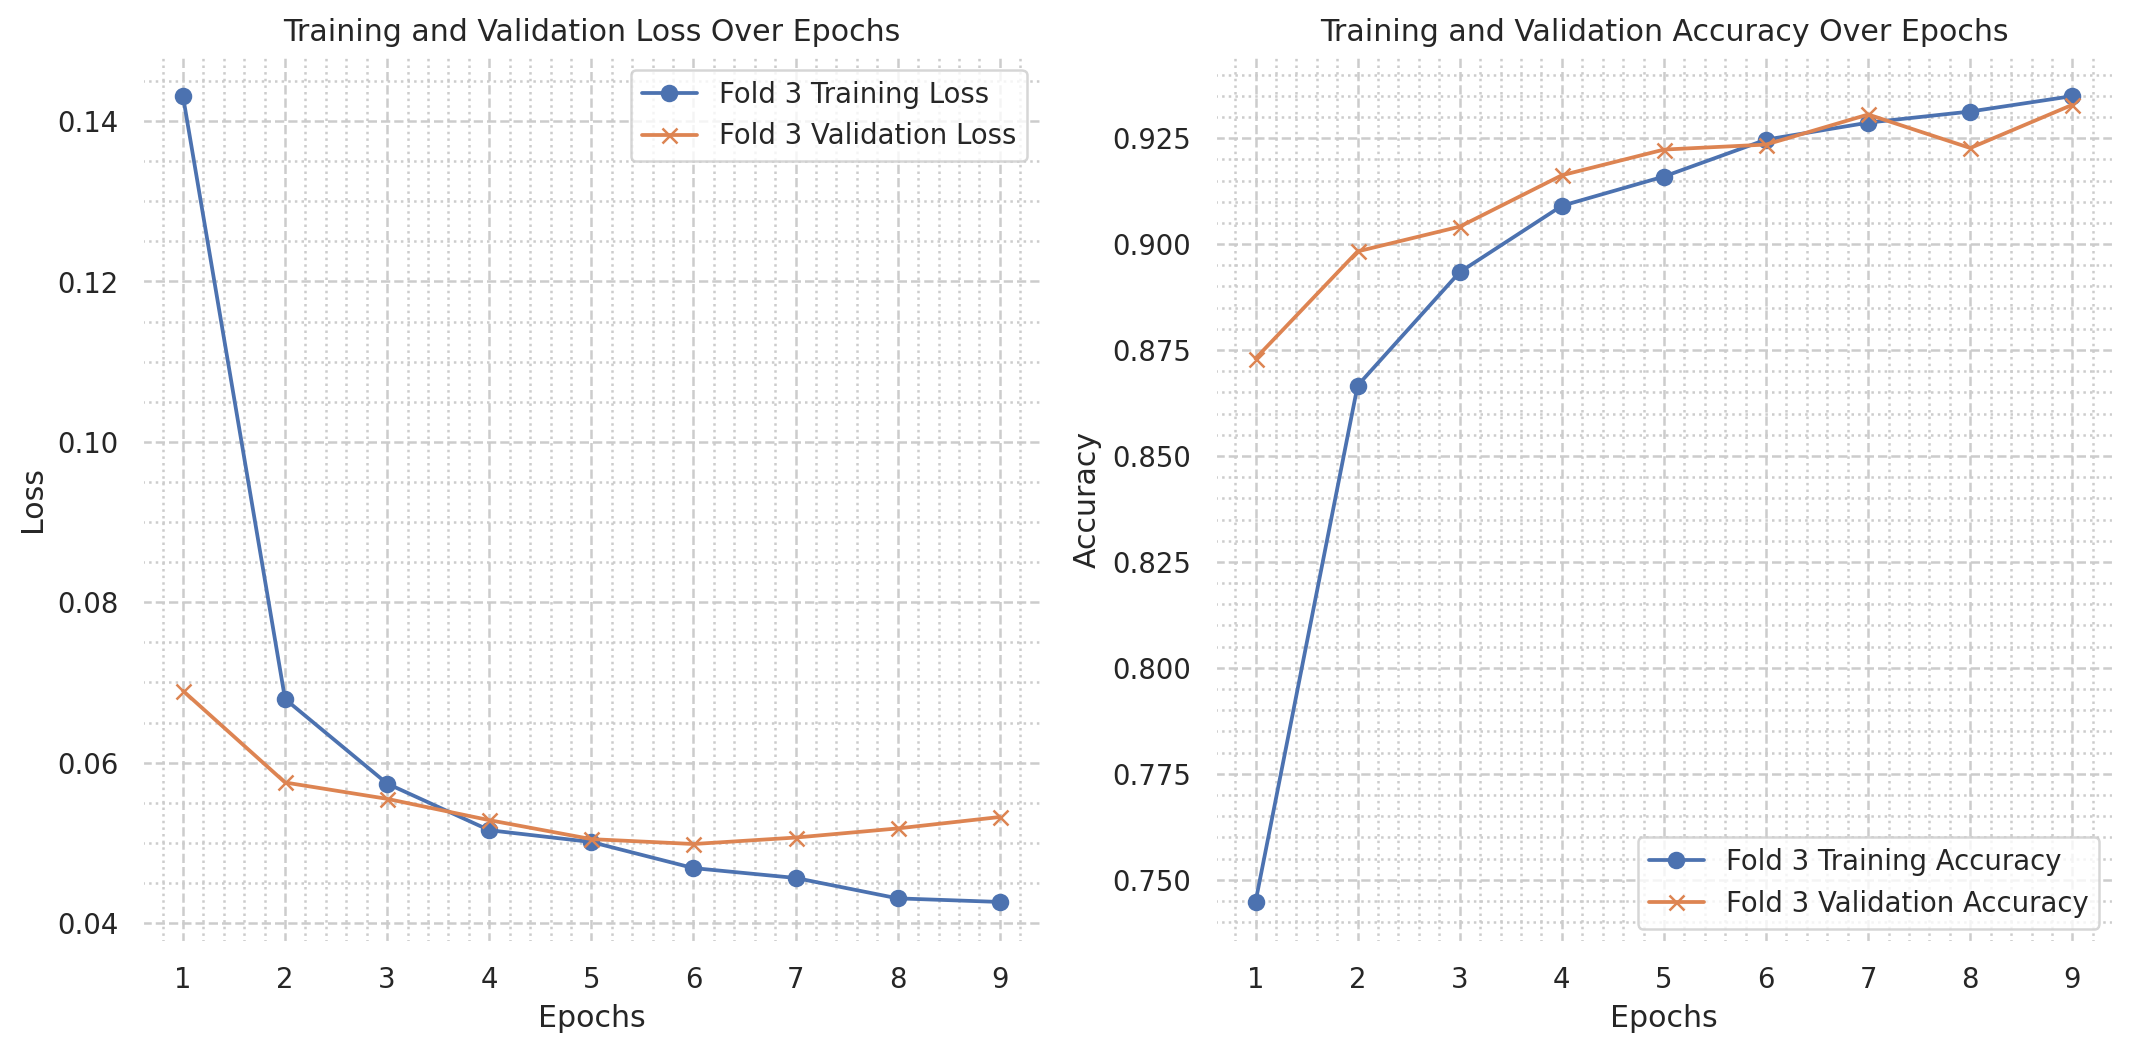


Starting Fold 4/5
Epoch 1/20
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 51s 29ms/step - accuracy: 0.6453 - loss: 0.2229 - val_accuracy: 0.8703 - val_loss: 0.0691 - learning_rate: 0.0010
Epoch 2/20
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 48s 28ms/step - accuracy: 0.8616 - loss: 0.0700 - val_accuracy: 0.8969 - val_loss: 0.0567 - learning_rate: 0.0010
Epoch 3/20
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 48s 29ms/step - accuracy: 0.8919 - loss: 0.0572 - val_accuracy: 0.9121 - val_loss: 0.0506 - learning_rate: 0.0010
Epoch 4/20
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 48s 28ms/step - accuracy: 0.9105 - loss: 0.0499 - val_accuracy: 0.9193 - val_loss: 0.0501 - learning_rate: 0.0010
Epoch 5/20
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 48s 28ms/step - accuracy: 0.9172 - loss: 0.0495 - val_accuracy: 0.9209 - val_loss: 0.0497 - learning_rate: 0.0010
Epoch 6/20
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 48s 29ms/step - accuracy: 0.9240 - loss: 0.0467 - val_accuracy: 0.9313 - val_loss: 0.0493 - learning_rate: 0.0010
Epoch 7/20
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 48s

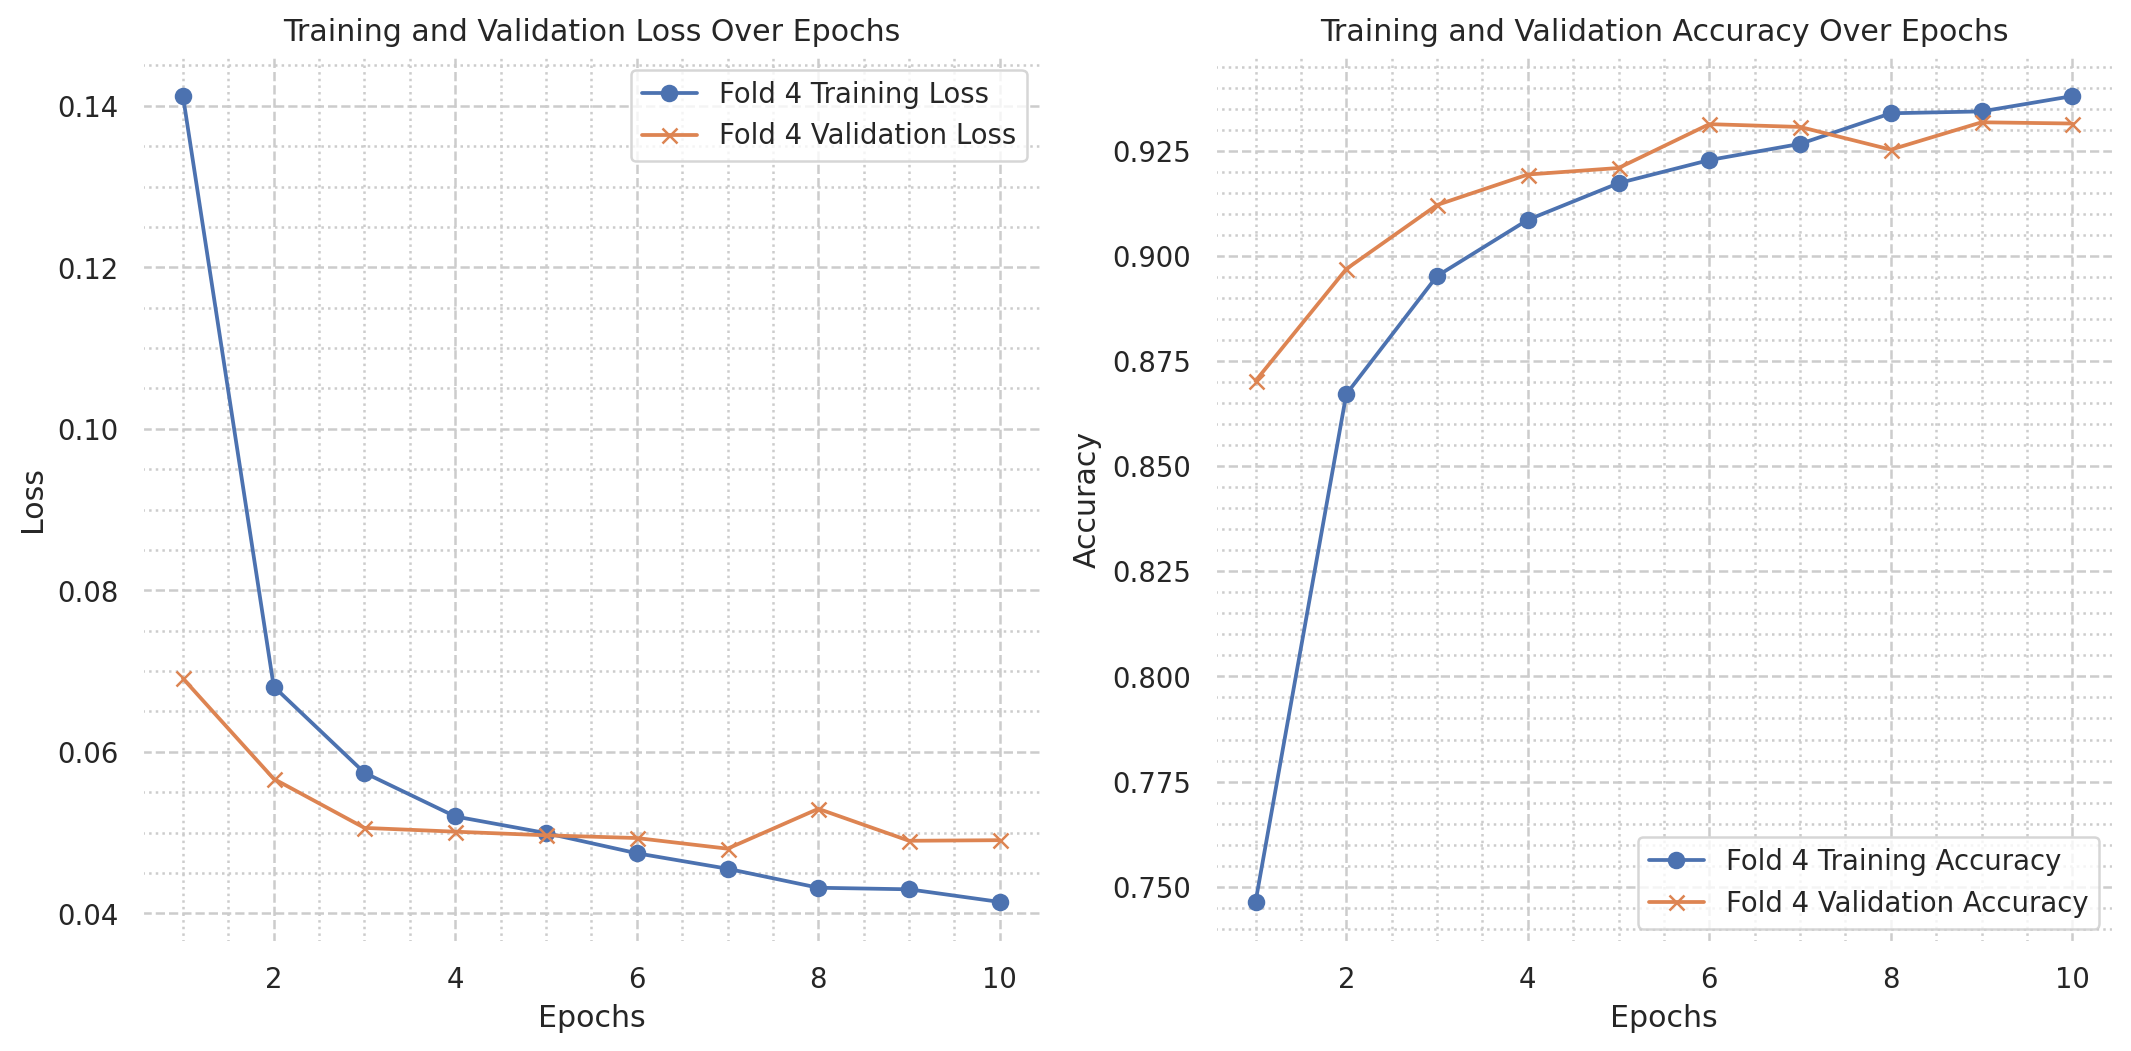


Starting Fold 5/5
Epoch 1/20
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 51s 29ms/step - accuracy: 0.6416 - loss: 0.2283 - val_accuracy: 0.8683 - val_loss: 0.0683 - learning_rate: 0.0010
Epoch 2/20
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 49s 29ms/step - accuracy: 0.8610 - loss: 0.0708 - val_accuracy: 0.8966 - val_loss: 0.0546 - learning_rate: 0.0010
Epoch 3/20
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 50s 29ms/step - accuracy: 0.8907 - loss: 0.0573 - val_accuracy: 0.9089 - val_loss: 0.0519 - learning_rate: 0.0010
Epoch 4/20
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 49s 29ms/step - accuracy: 0.9096 - loss: 0.0500 - val_accuracy: 0.9160 - val_loss: 0.0515 - learning_rate: 0.0010
Epoch 5/20
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 50s 30ms/step - accuracy: 0.9200 - loss: 0.0474 - val_accuracy: 0.9212 - val_loss: 0.0509 - learning_rate: 0.0010
Epoch 6/20
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 50s 29ms/step - accuracy: 0.9263 - loss: 0.0448 - val_accuracy: 0.9244 - val_loss: 0.0526 - learning_rate: 0.0010
Epoch 7/20
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 49s

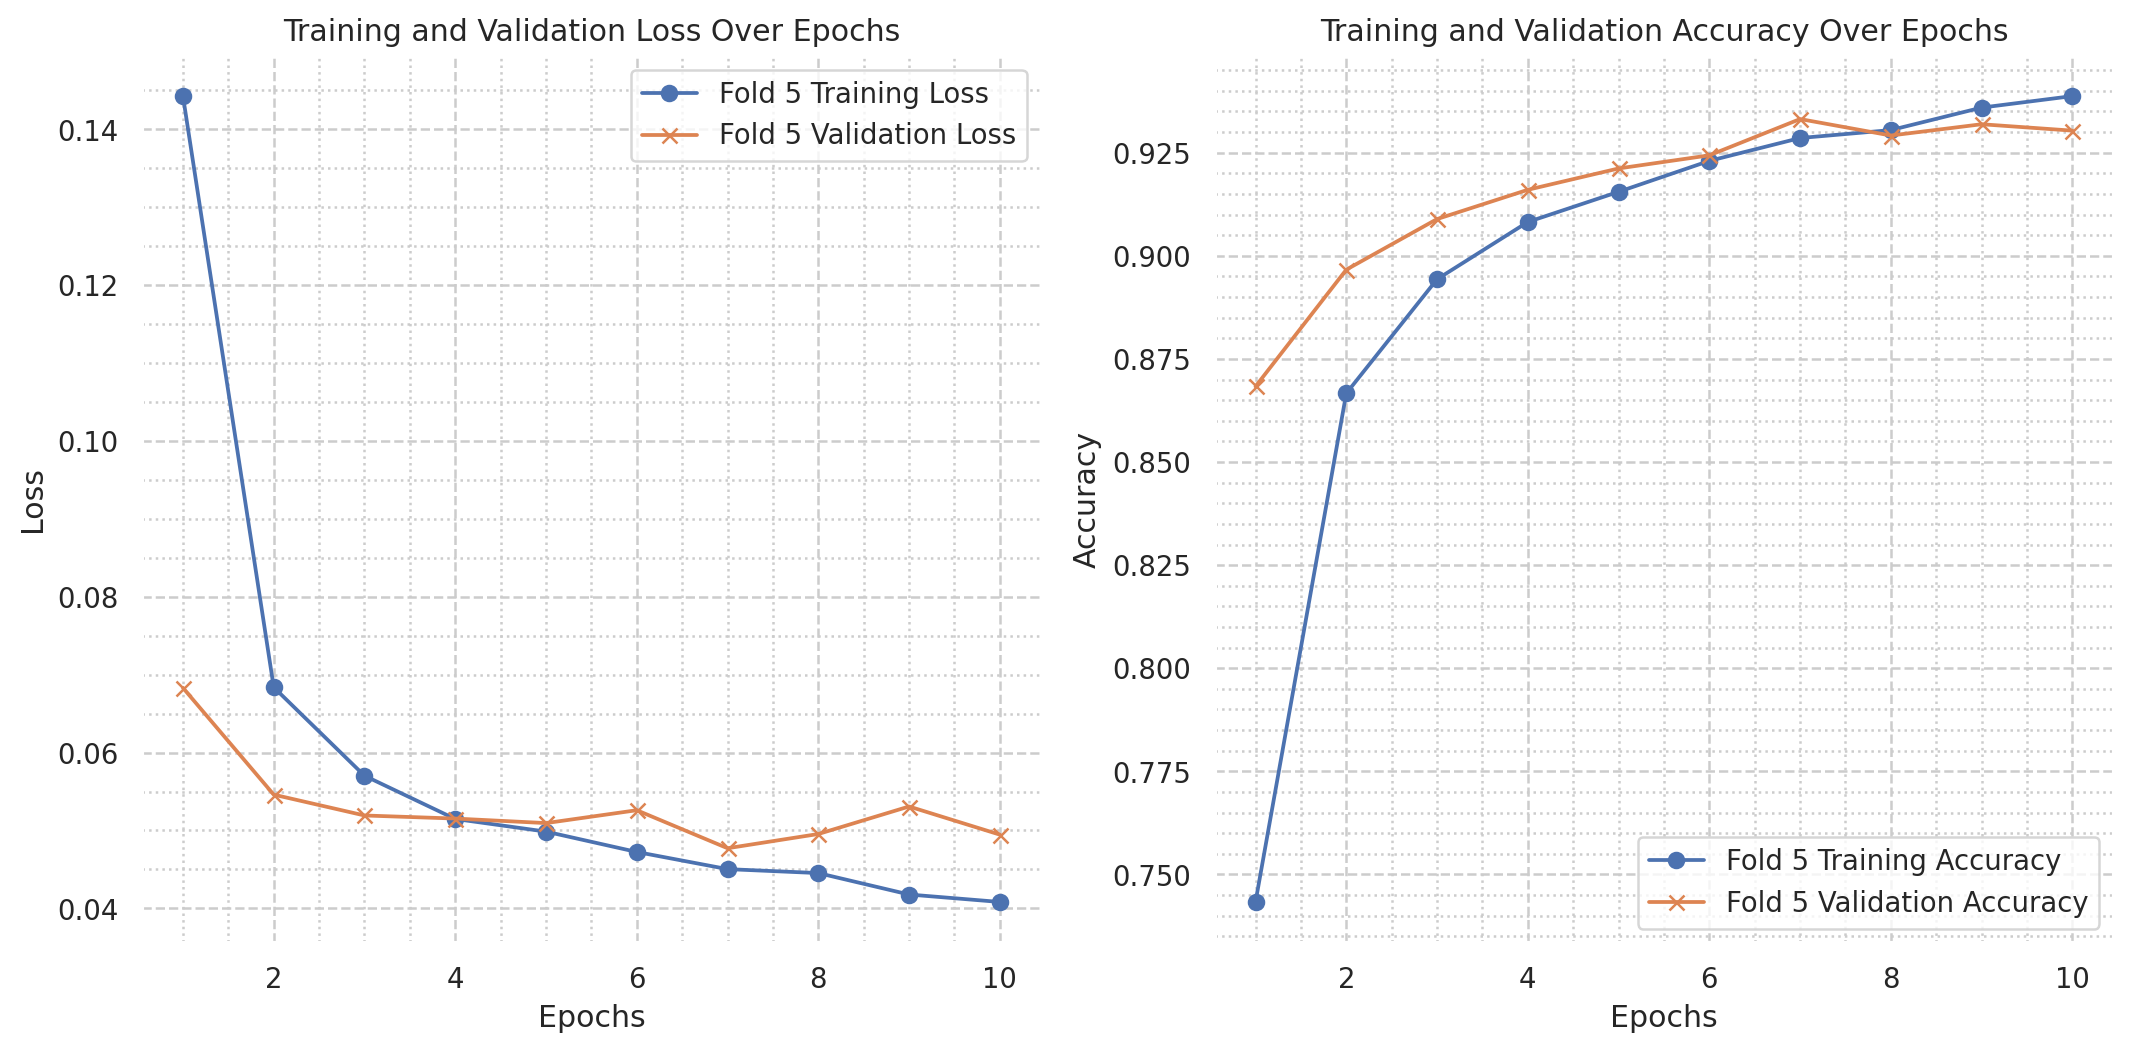


Average Training Loss: 0.0411
Average Validation Loss: 0.0515
Average Training Accuracy: 0.9384
Average Validation Accuracy: 0.9316


In [9]:
# TensorFlow Probability shortcuts
tfd = tfp.distributions
tfpl = tfp.layers

# Set Up Visualizations
plt.rcParams['figure.dpi'] = 180
plt.rcParams["figure.figsize"] = (10, 8)
sns.set_theme(rc={
    'axes.facecolor': '#FFFFFF',
    'figure.facecolor': '#FFFFFF',
    'font.sans-serif': 'DejaVu Sans',
    'font.family': 'sans-serif'
})

#####################################
# Load and Prepare Data
#####################################


# Define Categorical and Numerical Features
categorical_features = [
    'quarter', 'down', 'offenseFormation', 'play_type', 
    'defenseFormation', 'pff_manZone', 'game_half', 'is_second_half', 
    'offense_defense_interaction', 'yardsGained'
]
numerical_features = [
    'yardsToGo', 'absoluteYardlineNumber', 'average_offense_rating', 
    'average_defense_rating', 'quarter_seconds_remaining', 
    'half_seconds_remaining', 'game_seconds_remaining', 
    'score_differential', 'wp', 'def_wp', 
    'down_yardsToGo', 'quarter_time_ratio', 'half_time_ratio', 
    'posteam_timeout_usage', 'defteam_timeout_usage', 'normalized_down', 
    'normalized_quarter', 'normalized_time_remaining', 'situation_pressure', 
    'goal_to_go', 'blocking_ratio', 'routes_ratio', 'special_actions_ratio', 
    'no_assignment_ratio', 'run_defense_ratio', 'zone_defense_ratio', 
    'man_defense_ratio', 'pass_rush_ratio', 'miscellaneous_ratio', 
    'special_defense_ratio', 'skill_players_count', 'skill_players_ratio',
    'offensive_line_count', 'offensive_line_ratio', 'uncommon_positions_count', 
    'uncommon_positions_ratio', 'defensive_line_count', 'defensive_line_ratio',
    'linebackers_count', 'linebackers_ratio', 'defensive_backs_count', 
    'defensive_backs_ratio', 'non_traditional_count', 'non_traditional_ratio'
]
target = 'strategy'


##########################################
# Encode Categorical Variables as Integers
##########################################

cat_mapping = {}
for cat_col in categorical_features:
    unique_vals = df[cat_col].astype(str).unique()
    cat_mapping[cat_col] = {val: i for i, val in enumerate(unique_vals)}
    df[cat_col] = df[cat_col].astype(str).map(cat_mapping[cat_col])

#####################################
# Scale Numerical Features
#####################################

scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

X_cats = df[categorical_features].values  
X_nums = df[numerical_features].values   

# Factorize the target variable
y_bins, y_labels = pd.factorize(df[target])

# Calculate class distribution
unique, counts = np.unique(y_bins, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class Distribution Before Resampling:", class_distribution)

# Identify classes with counts <=1
classes_to_remove = [cls for cls, cnt in class_distribution.items() if cnt <= 1]

if classes_to_remove:
    # Map class indices back to original labels
    classes_to_remove_labels = [y_labels[cls] for cls in classes_to_remove]
    print(f"Removing classes with <=1 samples: {classes_to_remove_labels}")
    
    # Remove these classes from the DataFrame
    df_filtered = df[~df[target].isin(classes_to_remove_labels)].copy()
    
    # Re-factorize the target variable
    y_bins_filtered, y_labels_filtered = pd.factorize(df_filtered[target])
    
    # Update feature variables
    X_cats = df_filtered[categorical_features].values
    X_nums = df_filtered[numerical_features].values
    X_combined = np.hstack([X_cats, X_nums])
    
    # Recompute class distribution
    unique_filtered, counts_filtered = np.unique(y_bins_filtered, return_counts=True)
    class_distribution_filtered = dict(zip(unique_filtered, counts_filtered))
    print("Class Distribution After Removing Low-count Classes:", class_distribution_filtered)
else:
    print("No classes with <=1 samples detected.")
    df_filtered = df.copy()
    y_bins_filtered, y_labels_filtered = y_bins, y_labels
    X_cats = df_filtered[categorical_features].values
    X_nums = df_filtered[numerical_features].values
    X_combined = np.hstack([X_cats, X_nums])

#####################################
# Handle Class Imbalance with SMOTETomek
#####################################

smote_tomek = SMOTETomek(smote=SMOTE(random_state=512, k_neighbors=1))
X_resampled, y_resampled = smote_tomek.fit_resample(X_combined, y_bins_filtered)

X_cats_resampled = X_resampled[:, :X_cats.shape[1]]
X_nums_resampled = X_resampled[:, X_cats.shape[1]:]

num_classes = len(np.unique(y_resampled))

# Update Vocabulary Sizes
cat_vocab_sizes = []
for cat_col in categorical_features:
    cat_vocab_sizes.append(len(cat_mapping[cat_col]))

#####################################
# Define Focal Loss
#####################################

def focal_loss_fixed(y_true, y_pred, gamma=2., alpha=.25):
    epsilon = 1e-6
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    cross_entropy = -y_true * tf.math.log(y_pred)
    weight = alpha * tf.math.pow(1 - y_pred, gamma)
    loss = weight * cross_entropy
    return tf.reduce_mean(tf.reduce_sum(loss, axis=1))

#####################################
# Build Model with Separate Input Layers & Debug Prints
#####################################

def build_model(cat_vocab_sizes, num_numeric, num_classes, embedding_dim=8, hidden_units=128, dropout_rate=0.2):
    # Single input for all categorical features
    cat_input = tf.keras.Input(shape=(len(cat_vocab_sizes),), name="categorical_input", dtype=tf.int32)
    
    # Embedding layers
    cat_embeddings = []
    for i, vocab_size in enumerate(cat_vocab_sizes):
        embed_layer = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, name=f"embedding_{i}")
        embed_cat = embed_layer(cat_input[:, i])
        cat_embeddings.append(embed_cat)
    
    # Concatenate all embeddings
    cat_emb_concat = tf.keras.layers.Concatenate(axis=1)(cat_embeddings)

    # Define numerical input
    num_input = tf.keras.Input(shape=(num_numeric,), name="numerical_input", dtype=tf.float32)

    # Combine categorical and numerical features
    combined = tf.keras.layers.Concatenate()([cat_emb_concat, num_input])

    # Hidden layer
    x = tf.keras.layers.Dense(hidden_units, activation='relu', name="dense")(combined)

    # Dropout
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Output layer
    logits = tf.keras.layers.Dense(num_classes, name="output")(x)

    # Softmax activation
    probabilities = tf.keras.layers.Softmax()(logits)

    # Define the model
    model = tf.keras.Model(inputs=[cat_input, num_input], outputs=probabilities)
    return model


# def build_enhanced_model(
#     cat_vocab_sizes, 
#     num_numeric, 
#     num_classes, 
#     embedding_dim=64,  # Embedding dimension
#     hidden_units=[512, 512],  # Two hidden layers
#     dropout_rate=0.3,  # Dropout rate
#     l2_reg=1e-5  # L2 regularization strength
# ):
#     # Categorical Inputs
#     cat_input = tf.keras.Input(shape=(len(cat_vocab_sizes),), name="categorical_input", dtype=tf.int32)
    
#     # Embedding Layers
#     cat_embeddings = []
#     for i, vocab_size in enumerate(cat_vocab_sizes):
#         embed_layer = tf.keras.layers.Embedding(
#             input_dim=vocab_size, 
#             output_dim=embedding_dim, 
#             name=f"embedding_{i}",
#             embeddings_regularizer=tf.keras.regularizers.l2(l2_reg)
#         )
#         embed_cat = embed_layer(cat_input[:, i])
#         cat_embeddings.append(embed_cat)
    
#     # Concatenate Embeddings
#     cat_emb_concat = tf.keras.layers.Concatenate(axis=1)(cat_embeddings)
    
#     # Numerical Inputs
#     num_input = tf.keras.Input(shape=(num_numeric,), name="numerical_input", dtype=tf.float32)
    
#     # Batch Normalization on Numerical Inputs
#     num_normalized = tf.keras.layers.BatchNormalization()(num_input)
    
#     # Combine Categorical and Numerical Features
#     combined = tf.keras.layers.Concatenate()([cat_emb_concat, num_normalized])
    
#     # First Hidden Layer
#     x = tf.keras.layers.Dense(
#         hidden_units[0], 
#         activation='swish',  # Swish Activation
#         kernel_regularizer=tf.keras.regularizers.l2(l2_reg)
#     )(combined)
#     x = tf.keras.layers.Dropout(dropout_rate)(x)
    
#     # Second Hidden Layer
#     x = tf.keras.layers.Dense(
#         hidden_units[1], 
#         activation='swish',  # Swish Activation
#         kernel_regularizer=tf.keras.regularizers.l2(l2_reg)
#     )(x)
#     x = tf.keras.layers.Dropout(dropout_rate)(x)
    
#     # Output Layer
#     logits = tf.keras.layers.Dense(
#         num_classes, 
#         kernel_regularizer=tf.keras.regularizers.l2(l2_reg), 
#         name="output"
#     )(x)
    
#     # Softmax Activation
#     probabilities = tf.keras.layers.Activation('softmax')(logits)
    
#     # Define the Model
#     model = tf.keras.Model(inputs=[cat_input, num_input], outputs=probabilities)
#     return model


def build_enhanced_model(
    cat_vocab_sizes, 
    num_numeric, 
    num_classes, 
    embedding_dim=16,  # Embedding dimension
    hidden_units=[2048, 2048],  # Two hidden layers
    dropout_rate=0.1,  # Dropout rate
    l2_reg=1e-6  # L2 regularization strength
):
    # Categorical Inputs
    cat_input = tf.keras.Input(shape=(len(cat_vocab_sizes),), name="categorical_input", dtype=tf.int32)
    
    # Embedding Layers
    cat_embeddings = []
    for i, vocab_size in enumerate(cat_vocab_sizes):
        embed_layer = tf.keras.layers.Embedding(
            input_dim=vocab_size, 
            output_dim=embedding_dim, 
            name=f"embedding_{i}",
            embeddings_regularizer=tf.keras.regularizers.l2(l2_reg)
        )
        embed_cat = embed_layer(cat_input[:, i])
        cat_embeddings.append(embed_cat)
    
    # Concatenate Embeddings
    cat_emb_concat = tf.keras.layers.Concatenate(axis=1)(cat_embeddings)
    
    # Numerical Inputs
    num_input = tf.keras.Input(shape=(num_numeric,), name="numerical_input", dtype=tf.float32)
    
    # Batch Normalization on Numerical Inputs
    num_normalized = tf.keras.layers.BatchNormalization()(num_input)
    
    # Combine Categorical and Numerical Features
    combined = tf.keras.layers.Concatenate()([cat_emb_concat, num_normalized])
    
    # First Hidden Layer
    x = tf.keras.layers.Dense(
        hidden_units[0], 
        activation='swish',  # Swish Activation
        kernel_regularizer=tf.keras.regularizers.l2(l2_reg)
    )(combined)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    # Second Hidden Layer
    x = tf.keras.layers.Dense(
        hidden_units[1], 
        activation='swish',  # Swish Activation
        kernel_regularizer=tf.keras.regularizers.l2(l2_reg)
    )(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    # Output Layer
    logits = tf.keras.layers.Dense(
        num_classes, 
        kernel_regularizer=tf.keras.regularizers.l2(l2_reg), 
        name="output"
    )(x)
    
    # Softmax Activation
    probabilities = tf.keras.layers.Activation('softmax')(logits)
    
    # Define the Model
    model = tf.keras.Model(inputs=[cat_input, num_input], outputs=probabilities)
    return model



#####################################
# Define Focal Loss
#####################################

def focal_loss(y_true, y_pred, gamma=1.5, alpha=0.25):
    y_true_one_hot = tf.one_hot(y_true, depth=y_pred.shape[-1])
    cross_entropy_loss = -y_true_one_hot * tf.math.log(y_pred + 1e-6)
    focal_modulation = tf.pow(1 - y_pred, gamma)
    loss = alpha * focal_modulation * cross_entropy_loss
    return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))


#####################################
# Plot Training and Validation Metrics
#####################################

def plot_training_validation_metrics(train_losses, val_losses, train_accuracies, val_accuracies, fold):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 6))
    
    # Plot Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label=f'Fold {fold} Training Loss', marker='o')
    plt.plot(epochs, val_losses, label=f'Fold {fold} Validation Loss', marker='x')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(which='major', color='#CCCCCC', linestyle='--')
    plt.grid(which='minor', color='#CCCCCC', linestyle=':')
    plt.minorticks_on()
    # plt.ylim(0, 1.5)
    # plt.yticks(np.arange(0, 1.6, 0.1))
    
    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label=f'Fold {fold} Training Accuracy', marker='o')
    plt.plot(epochs, val_accuracies, label=f'Fold {fold} Validation Accuracy', marker='x')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(which='major', color='#CCCCCC', linestyle='--')
    plt.grid(which='minor', color='#CCCCCC', linestyle=':')
    plt.minorticks_on()
    
    plt.tight_layout()
    plt.show()




class EarlyStoppingByLossThreshold(tf.keras.callbacks.Callback):
    def __init__(self, monitor='loss', threshold=0.01, patience=10):
        super(EarlyStoppingByLossThreshold, self).__init__()
        self.monitor = monitor
        self.threshold = threshold
        self.patience = patience
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            print(f"EarlyStoppingByLossThreshold requires {self.monitor} available!")
            return

        if current <= self.threshold:
            self.wait += 1
            print(f"Epoch {epoch+1}: {self.monitor} is below {self.threshold} (count: {self.wait}/{self.patience})")
            if self.wait >= self.patience:
                print(f"\nEarly stopping triggered. {self.monitor} has been below {self.threshold} for {self.patience} consecutive epochs.")
                self.model.stop_training = True
        else:
            if self.wait > 0:
                print(f"Epoch {epoch+1}: {self.monitor} has risen above {self.threshold}. Resetting patience counter.")
            self.wait = 0


#####################################
# Training Parameters
#####################################

batch_size = 32
n_splits = 5
num_epochs = 20
early_stopping_patience = 3 

#####################################
# Prepare Data for Cross-Validation
#####################################

X_res_cat = X_cats_resampled
X_res_num = X_nums_resampled
y_resampled_categorical = tf.keras.utils.to_categorical(y_resampled, num_classes=num_classes)

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

all_fold_train_losses = []
all_fold_val_losses = []
all_fold_train_accuracies = []
all_fold_val_accuracies = []


#####################################
# K-Fold Cross-Validation Loop with model.fit and Callbacks
#####################################

for fold, (train_index, val_index) in enumerate(skf.split(X_res_cat, y_resampled), start=1):
    print(f"\nStarting Fold {fold}/{n_splits}")
    
    # Split data into training and validation sets for this fold
    X_train_fold_cat, X_val_cat = X_res_cat[train_index], X_res_cat[val_index]
    X_train_fold_num, X_val_num = X_res_num[train_index], X_res_num[val_index]
    y_train_fold, y_val_fold = y_resampled_categorical[train_index], y_resampled_categorical[val_index]

    # Build a fresh model for each fold
    model = build_enhanced_model(
        cat_vocab_sizes=cat_vocab_sizes,
        num_numeric=len(numerical_features),
        num_classes=num_classes,
    )
    
    # Compile the model with Nadam optimizer and categorical crossentropy
    optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss=focal_loss_fixed,  # Or use focal_loss_fixed
        metrics=['accuracy']
    )
    
    # Define Callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=early_stopping_patience, 
        restore_best_weights=True
    )
    
    lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=5, 
        min_lr=1e-6
    )
    
    # Custom Early Stopping Callback
    custom_early_stop = EarlyStoppingByLossThreshold()
    
    # List of Callbacks
    callbacks = [early_stop, lr_reduce, custom_early_stop]
        
    # Fit the Model
    history = model.fit(
        x={'categorical_input': X_train_fold_cat, 'numerical_input': X_train_fold_num},
        y=y_train_fold,
        validation_data=(
            {'categorical_input': X_val_cat, 'numerical_input': X_val_num},
            y_val_fold
        ),
        epochs=num_epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate the Model on Validation Data
    val_loss, val_accuracy = model.evaluate(
        {'categorical_input': X_val_cat, 'numerical_input': X_val_num},
        y_val_fold,
        verbose=0
    )
    
    print(f"Fold {fold} Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    # Plot Metrics for This Fold
    plot_training_validation_metrics(
        history.history['loss'], 
        history.history['val_loss'], 
        history.history['accuracy'], 
        history.history['val_accuracy'], 
        fold
    )
    
    # Store Fold Metrics
    all_fold_train_losses.append(history.history['loss'][-1])
    all_fold_val_losses.append(history.history['val_loss'][-1])
    all_fold_train_accuracies.append(history.history['accuracy'][-1])
    all_fold_val_accuracies.append(history.history['val_accuracy'][-1])

#####################################
# Report Final Metrics Across Folds
#####################################

print(f"\nAverage Training Loss: {np.mean(all_fold_train_losses):.4f}")
print(f"Average Validation Loss: {np.mean(all_fold_val_losses):.4f}")
print(f"Average Training Accuracy: {np.mean(all_fold_train_accuracies):.4f}")
print(f"Average Validation Accuracy: {np.mean(all_fold_val_accuracies):.4f}")




#####################################
# Prediction Simulator Helper function
#####################################
def predict_strategy_sorted(game_scenario, model, cat_features, cat_mapping, numerical_features, scaler, y_labels):
    # Create a DataFrame for the single game scenario
    scenario_df = pd.DataFrame([game_scenario])
    
    # Convert categorical features using cat_mapping
    for cat_col in cat_features:
        scenario_df[cat_col] = scenario_df[cat_col].astype(str).map(cat_mapping[cat_col])
    
    # Handle possible unseen categories by assigning a default index (e.g., 'unknown' or 0)
    for cat_col in cat_features:
        if scenario_df[cat_col].isnull().any():
            unknown_index = cat_mapping[cat_col].get('unknown', 0)
            scenario_df[cat_col] = scenario_df[cat_col].fillna(unknown_index).astype(int)
    
    # Scale numerical features
    scenario_df[numerical_features] = scaler.transform(scenario_df[numerical_features])
    
    # Separate categorical and numerical data
    X_cat = scenario_df[cat_features].values  # shape: (1, num_cats)
    X_num = scenario_df[numerical_features].values  # shape: (1, num_numeric)

    # Convert to tensors with appropriate data types
    X_cat_tensor = tf.convert_to_tensor(X_cat, dtype=tf.int32)
    X_num_tensor = tf.convert_to_tensor(X_num, dtype=tf.float32)

    # Predict probabilities by passing inputs as a list
    y_pred = model([X_cat_tensor, X_num_tensor], training=False)
    
    # Extract probabilities
    probabilities = y_pred.numpy()[0]

    # Create a dictionary and sort by probability in descending order
    bin_probs = {y_labels[i]: float(prob) for i, prob in enumerate(probabilities)}
    sorted_probs = dict(sorted(bin_probs.items(), key=lambda item: item[1], reverse=True))
    
    return sorted_probs


In [10]:
# Define a directory to save models and components
save_dir = 'tensorflow_models/off_strategy'
os.makedirs(save_dir, exist_ok=True)
print(f"Directory '{save_dir}' is ready for saving models and components.")

# Define the path to save the model
offense_strategy_model_file = os.path.join(save_dir, 'offense_strategy_model.keras')

# Save the trained TensorFlow/Keras model format
model.save(offense_strategy_model_file)
print(f"TensorFlow model saved successfully as {offense_strategy_model_file}.")

# Path to save cat_mapping
offense_strategy_cat_mapping_file = os.path.join(save_dir, 'offense_strategy_cat_mapping.json')

# Save cat_mapping to a JSON file
with open(offense_strategy_cat_mapping_file, 'w') as f:
    json.dump(cat_mapping, f)
print(f"Categorical mapping saved successfully as {offense_strategy_cat_mapping_file}.")

# Path to save the scaler
offense_strategy_scaler_file = os.path.join(save_dir, 'offense_strategy_scaler.joblib')

# Save the scaler using joblib
joblib.dump(scaler, offense_strategy_scaler_file)
print(f"Scaler saved successfully as {offense_strategy_scaler_file}.")

# Path to save y_labels
offense_strategy_y_labels_file = os.path.join(save_dir, 'offense_strategy_y_labels.json')

# Save y_labels to a JSON file
with open(offense_strategy_y_labels_file, 'w') as f:
    json.dump(y_labels_filtered.tolist(), f)
print(f"Y-labels saved successfully as {offense_strategy_y_labels_file}.")

Directory 'tensorflow_models/off_strategy' is ready for saving models and components.
TensorFlow model saved successfully as tensorflow_models/off_strategy/offense_strategy_model.keras.
Categorical mapping saved successfully as tensorflow_models/off_strategy/offense_strategy_cat_mapping.json.
Scaler saved successfully as tensorflow_models/off_strategy/offense_strategy_scaler.joblib.
Y-labels saved successfully as tensorflow_models/off_strategy/offense_strategy_y_labels.json.


In [11]:
# Load the trained model
offense_strategy_model_file = os.path.join(save_dir, 'offense_strategy_model.keras')
offense_strategy_model = tf.keras.models.load_model(offense_strategy_model_file, compile=False, custom_objects={'focal_loss_fixed': focal_loss_fixed})
print(f"Model loaded successfully from {offense_strategy_model_file} without compiling.")

# Load cat_mapping
offense_strategy_cat_mapping_file = os.path.join(save_dir, 'offense_strategy_cat_mapping.json')
with open(offense_strategy_cat_mapping_file, 'r') as f:
    offense_strategy_cat_mapping = json.load(f)
print(f"Categorical mapping loaded from {offense_strategy_cat_mapping_file}.")

# Load the scaler
offense_strategy_scaler_file = os.path.join(save_dir, 'offense_strategy_scaler.joblib')
offense_strategy_scaler = joblib.load(offense_strategy_scaler_file)
print(f"Scaler loaded from {offense_strategy_scaler_file}.")

# Load y_labels
offense_strategy_y_labels_file = os.path.join(save_dir, 'offense_strategy_y_labels.json')
with open(offense_strategy_y_labels_file, 'r') as f:
    offense_strategy_y_labels = json.load(f)
print(f"Y-labels loaded from {offense_strategy_y_labels_file}.")


Model loaded successfully from tensorflow_models/off_strategy/offense_strategy_model.keras without compiling.
Categorical mapping loaded from tensorflow_models/off_strategy/offense_strategy_cat_mapping.json.
Scaler loaded from tensorflow_models/off_strategy/offense_strategy_scaler.joblib.
Y-labels loaded from tensorflow_models/off_strategy/offense_strategy_y_labels.json.


In [12]:

# Get all the game scenarios for unseen data
game_scenarios = []
for _, row in unseen_data_df.iterrows():
    game_scenario = {
        'quarter': row['quarter'],
        'down': row['down'],
        'yardsToGo': row['yardsToGo'],
        'absoluteYardlineNumber': row['absoluteYardlineNumber'],
        'offenseFormation': row['offenseFormation'],
        'play_type': row['play_type'],
        'defenseFormation': row['defenseFormation'],
        'pff_manZone': row['pff_manZone'],
        'average_offense_rating': row['average_offense_rating'],
        'average_defense_rating': row['average_defense_rating'],
        'blocking_ratio': row['blocking_ratio'],
        'routes_ratio': row['routes_ratio'],
        'special_actions_ratio': row['special_actions_ratio'],
        'no_assignment_ratio': row['no_assignment_ratio'],
        'run_defense_ratio': row['run_defense_ratio'],
        'zone_defense_ratio': row['zone_defense_ratio'],
        'man_defense_ratio': row['man_defense_ratio'],
        'pass_rush_ratio': row['pass_rush_ratio'],
        'miscellaneous_ratio': row['miscellaneous_ratio'],
        'special_defense_ratio': row['special_defense_ratio'],
        'skill_players_count': row['skill_players_count'],
        'skill_players_ratio': row['skill_players_ratio'],
        'offensive_line_count': row['offensive_line_count'],
        'offensive_line_ratio': row['offensive_line_ratio'],
        'uncommon_positions_count': row['uncommon_positions_count'],
        'uncommon_positions_ratio': row['uncommon_positions_ratio'],
        'defensive_line_count': row['defensive_line_count'],
        'defensive_line_ratio': row['defensive_line_ratio'],
        'linebackers_count': row['linebackers_count'],
        'linebackers_ratio': row['linebackers_ratio'],
        'defensive_backs_count': row['defensive_backs_count'],
        'defensive_backs_ratio': row['defensive_backs_ratio'],
        'non_traditional_count': row['non_traditional_count'],
        'non_traditional_ratio': row['non_traditional_ratio'],
        'quarter_seconds_remaining': row['quarter_seconds_remaining'],
        'half_seconds_remaining': row['half_seconds_remaining'],
        'game_seconds_remaining': row['game_seconds_remaining'],
        'game_half': row['game_half'],
        'goal_to_go': row['goal_to_go'],
        'score_differential': row['score_differential'],
        'wp': row['wp'],
        'def_wp': row['def_wp'],
        'down_yardsToGo': row['down_yardsToGo'],
        'quarter_time_ratio': row['quarter_time_ratio'],
        'half_time_ratio': row['half_time_ratio'],
        'posteam_timeout_usage': row['posteam_timeout_usage'],
        'defteam_timeout_usage': row['defteam_timeout_usage'],
        'is_second_half': row['is_second_half'],
        'normalized_down': row['normalized_down'],
        'normalized_quarter': row['normalized_quarter'],
        'normalized_time_remaining': row['normalized_time_remaining'],
        'situation_pressure': row['situation_pressure'],
        'offense_defense_interaction': row['offense_defense_interaction'],
        'yardsGained': row['yardsGained']
    }
    game_scenarios.append(game_scenario)

# Print the extracted game_scenarios
# for i, scenario in enumerate(game_scenarios, 1):
#     print(f"Game Scenario {i}: {scenario}")


match_count = 0
mismatch_count = 0
perfect_match_count = 0
top2_match_count = 0 
total_scenarios = len(game_scenarios)


for i, (game_scenario, actual_strategy) in enumerate(zip(game_scenarios, unseen_data_df['strategy']), start=1):
    strategy_probabilities = predict_strategy_sorted(
        game_scenario=game_scenario, 
        model=offense_strategy_model, 
        cat_features=categorical_features, 
        cat_mapping=offense_strategy_cat_mapping, 
        numerical_features=numerical_features, 
        scaler=offense_strategy_scaler, 
        y_labels=offense_strategy_y_labels
    )
    
    sorted_bins = list(strategy_probabilities.keys()) 
    top_3 = sorted_bins[:3]
    top_2 = sorted_bins[:2] 
    top = sorted_bins[0]
    

    if actual_strategy in top_3:
        match_count += 1
        
        # Check if it's a perfect match (actual yards is the top predicted bin)
        if actual_strategy == top:
            perfect_match_count += 1
    else:
        mismatch_count += 1
        # Optionally, log or store mismatches if needed
    
    # New: Check for Top 2 match (actual yards in top 2 bins)
    if actual_strategy in top_2:
        top2_match_count += 1
    
    # Optional: Print scenario details for debugging
    # print(f"Scenario {i}:")
    # print(f"Predicted Yard Bin Probabilities: {json.dumps(bin_probabilities, indent=4, default=convert_numpy_types)}")
    # print(f"Actual Yards Gained: {actual_strategy}")
    # print(f"Top 3 Predicted Bins: {top_3_bins}")
    # print(f"Top 2 Predicted Bins: {top_2_bins}") 
    # print(f"Top Predicted Bin: {top_bin}\n")

# Calculate percentages
match_percentage = (match_count / total_scenarios) * 100
mismatch_percentage = (mismatch_count / total_scenarios) * 100
perfect_match_percentage = (perfect_match_count / total_scenarios) * 100
top2_match_percentage = (top2_match_count / total_scenarios) * 100 

# Print overall results
print(f"\nTotal Scenarios: {total_scenarios}")
print(f"Total Matches (Actual Yards in Top 3 Predictions): {match_count} ({match_percentage:.2f}%)")
print(f"Total Top 2 Matches (Actual Yards in Top 2 Predictions): {top2_match_count} ({top2_match_percentage:.2f}%)")  # New
print(f"Total Perfect Matches (Actual Yards as Top Prediction): {perfect_match_count} ({perfect_match_percentage:.2f}%)")
print(f"Total Mismatches: {mismatch_count} ({mismatch_percentage:.2f}%)")



Total Scenarios: 807
Total Matches (Actual Yards in Top 3 Predictions): 636 (78.81%)
Total Top 2 Matches (Actual Yards in Top 2 Predictions): 475 (58.86%)
Total Perfect Matches (Actual Yards as Top Prediction): 245 (30.36%)
Total Mismatches: 171 (21.19%)
